In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:

# Parameters
num_records = 50000  # Reduce dataset size for faster training
num_customers = 56
start_date = datetime(2018, 1, 1)
end_date = datetime(2023, 12, 31)
customer_ids = [f'CUST_{i}' for i in range(1, num_customers + 1)]
product_lines = ['Engine Parts', 'Brake System', 'Suspension', 'Electrical', 'Transmission']
customer_segments = ['A', 'B', 'C']
regions = ['Europe', 'Asia', 'North America', 'South America']
market_managers = [f'MGR_{i}' for i in range(1, 10)]


In [3]:
# Generate dataset
random.seed(42)
data = []

for _ in range(num_records):
    invoice_date = start_date + timedelta(days=random.randint(0, (end_date - start_date).days))
    customer_id = random.choice(customer_ids)
    product_line = random.choice(product_lines)
    customer_segment = random.choice(customer_segments)
    region = random.choice(regions)
    market_manager = random.choice(market_managers)
    pcs_sold = random.randint(1, 500)
    weight_kg = pcs_sold * random.uniform(0.5, 5.0)
    gross_value = pcs_sold * random.uniform(10, 500)
    discount_perc = random.uniform(0, 20)
    net_value = gross_value * (1 - discount_perc / 100)
    pln_usd = random.uniform(3.5, 4.5)
    eur_usd = random.uniform(1.1, 1.3)
    
    data.append([invoice_date, customer_id, product_line, customer_segment, region, market_manager,
                 pcs_sold, weight_kg, gross_value, discount_perc, net_value, pln_usd, eur_usd])

In [4]:
# Create DataFrame
df = pd.DataFrame(data, columns=['Invoice_date', 'Customer_ID', 'Product_Line', 'Customer_Segment',
                                 'Region', 'Market_Manager', 'PCS_Sold', 'Weight_KG', 'Gross_Value',
                                 'Discount_Perc', 'Net_Value', 'PLN_USD', 'EUR_USD'])

In [5]:
# Save to CSV
df.to_csv("synthetic_b2b_sales_data.csv", index=False)

In [6]:

# Ensure Invoice_date is a datetime index
df['Invoice_date'] = pd.to_datetime(df['Invoice_date'])
df = df.sort_values(by='Invoice_date')
df.set_index('Invoice_date', inplace=True)

# Feature Engineering
df['month'] = df.index.month
df['day'] = df.index.day
df['year'] = df.index.year
df['weekday'] = df.index.weekday
df['lag_30'] = df['Gross_Value'].shift(30)
df.dropna(inplace=True)


In [7]:

# Train-Test Split
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

X_train = train[['month', 'day', 'year', 'weekday', 'lag_30']]
y_train = train['Gross_Value']
X_test = test[['month', 'day', 'year', 'weekday', 'lag_30']]
y_test = test['Gross_Value']

In [8]:
# ARIMA Model
arima_model = ARIMA(y_train, order=(5,1,0))
arima_fit = arima_model.fit()
arima_pred = arima_fit.forecast(steps=len(test))

c:\Users\avenkatesh\AppData\Local\anaconda3\envs\churn-1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\avenkatesh\AppData\Local\anaconda3\envs\churn-1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\avenkatesh\AppData\Local\anaconda3\envs\churn-1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\avenkatesh\AppData\Local\anaconda3\envs\churn-1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported inde

In [9]:
# XGBoost Model
xgb_model = XGBRegressor(n_estimators=50, learning_rate=0.1, max_depth=3)  # Reduced n_estimators and depth for speed
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

In [10]:
# LSTM Model Optimization
scaler = StandardScaler()
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

X_train_lstm = np.reshape(X_train.values, (X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = np.reshape(X_test.values, (X_test.shape[0], X_test.shape[1], 1))

lstm_model = Sequential([
    LSTM(32, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(16, activation='relu'),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, y_train_scaled, epochs=5, batch_size=32, verbose=1)  # Optimized batch size
lstm_pred_scaled = lstm_model.predict(X_test_lstm)
lstm_pred = scaler.inverse_transform(lstm_pred_scaled)

Epoch 1/5


c:\Users\avenkatesh\AppData\Local\anaconda3\envs\churn-1\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 1865294.8750
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 3056.3076
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 1016.7410
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 521.0240
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 3534.1460
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [11]:
# Model Evaluation
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"{model_name} Performance:")
    print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%\n")

# Compare Models
evaluate_model(y_test, arima_pred, "ARIMA")
evaluate_model(y_test, xgb_pred, "XGBoost")
evaluate_model(y_test, lstm_pred, "LSTM")

ValueError: Length of values (247752) does not match length of index (19988)

Epoch 1/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 14372049.0000
Epoch 2/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1203292.8750
Epoch 3/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 58800.3203
Epoch 4/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 61413.3984
Epoch 5/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 22002.5371
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
ARIMA Performance:
MAE: 53070.12, MSE: 3650500246.80, RMSE: 60419.37, MAPE: 731.08%

XGBoost Performance:
MAE: 42946.06, MSE: 2724406026.01, RMSE: 52195.84, MAPE: 529.72%

LSTM Performance:
MAE: 1626842.28, MSE: 3243944959631.62, RMSE: 1801095.49, MAPE: 14564.05%



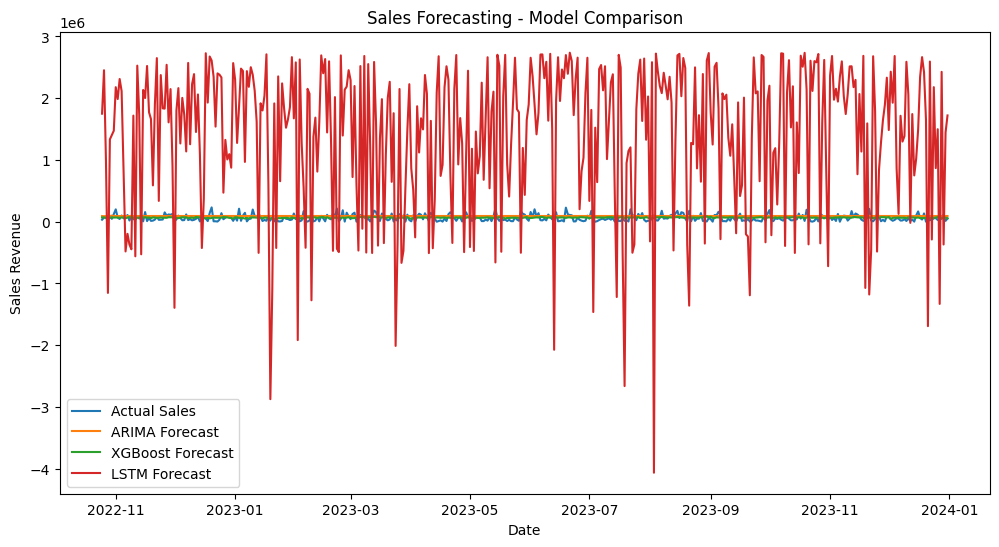

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Parameters
num_records = 50000  # Reduce dataset size for faster training
num_customers = 56
start_date = datetime(2018, 1, 1)
end_date = datetime(2023, 12, 31)
customer_ids = [f'CUST_{i}' for i in range(1, num_customers + 1)]
product_lines = ['Engine Parts', 'Brake System', 'Suspension', 'Electrical', 'Transmission']
customer_segments = ['A', 'B', 'C']
regions = ['Europe', 'Asia', 'North America', 'South America']
market_managers = [f'MGR_{i}' for i in range(1, 10)]

# Generate dataset
random.seed(42)
data = []

for _ in range(num_records):
    invoice_date = start_date + timedelta(days=random.randint(0, (end_date - start_date).days))
    customer_id = random.choice(customer_ids)
    product_line = random.choice(product_lines)
    customer_segment = random.choice(customer_segments)
    region = random.choice(regions)
    market_manager = random.choice(market_managers)
    pcs_sold = random.randint(1, 500)
    weight_kg = pcs_sold * random.uniform(0.5, 5.0)
    gross_value = pcs_sold * random.uniform(10, 500)
    discount_perc = random.uniform(0, 20)
    net_value = gross_value * (1 - discount_perc / 100)
    pln_usd = random.uniform(3.5, 4.5)
    eur_usd = random.uniform(1.1, 1.3)
    
    data.append([invoice_date, customer_id, product_line, customer_segment, region, market_manager,
                 pcs_sold, weight_kg, gross_value, discount_perc, net_value, pln_usd, eur_usd])

# Create DataFrame
df = pd.DataFrame(data, columns=['Invoice_date', 'Customer_ID', 'Product_Line', 'Customer_Segment',
                                 'Region', 'Market_Manager', 'PCS_Sold', 'Weight_KG', 'Gross_Value',
                                 'Discount_Perc', 'Net_Value', 'PLN_USD', 'EUR_USD'])

# Ensure Invoice_date is a datetime index
df['Invoice_date'] = pd.to_datetime(df['Invoice_date'])
df = df.sort_values(by='Invoice_date')
df.set_index('Invoice_date', inplace=True)

# Remove duplicate indices to avoid frequency errors
df = df[~df.index.duplicated(keep='first')]

# Infer and set frequency
df = df.asfreq('D')

# Feature Engineering
df['month'] = df.index.month
df['day'] = df.index.day
df['year'] = df.index.year
df['weekday'] = df.index.weekday
df['lag_30'] = df['Gross_Value'].shift(30)
df.dropna(inplace=True)

# Train-Test Split
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

X_train = train[['month', 'day', 'year', 'weekday', 'lag_30']]
y_train = train['Gross_Value']
X_test = test[['month', 'day', 'year', 'weekday', 'lag_30']]
y_test = test['Gross_Value']

# ARIMA Model
arima_model = ARIMA(y_train, order=(5,1,0))
arima_fit = arima_model.fit()
arima_pred = arima_fit.forecast(steps=len(test))

# XGBoost Model
xgb_model = XGBRegressor(n_estimators=50, learning_rate=0.1, max_depth=3)  # Reduced n_estimators and depth for speed
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

# LSTM Model Optimization
scaler = StandardScaler()
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

X_train_lstm = np.reshape(X_train.values, (X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = np.reshape(X_test.values, (X_test.shape[0], X_test.shape[1], 1))

lstm_model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    LSTM(32, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(16, activation='relu'),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, y_train_scaled, epochs=5, batch_size=32, verbose=1)  # Optimized batch size
lstm_pred_scaled = lstm_model.predict(X_test_lstm)
lstm_pred = scaler.inverse_transform(lstm_pred_scaled).flatten()

# Ensure predictions have the same length
arima_pred = np.array(arima_pred[:len(y_test)])
lstm_pred = np.array(lstm_pred[:len(y_test)])

# Model Evaluation
def evaluate_model(y_true, y_pred, model_name):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"{model_name} Performance:")
    print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%\n")

# Compare Models
evaluate_model(y_test, arima_pred, "ARIMA")
evaluate_model(y_test, xgb_pred, "XGBoost")
evaluate_model(y_test, lstm_pred, "LSTM")

# Plot Predictions
plt.figure(figsize=(12,6))
plt.plot(test.index, y_test, label='Actual Sales')
plt.plot(test.index, arima_pred, label='ARIMA Forecast')
plt.plot(test.index, xgb_pred, label='XGBoost Forecast')
plt.plot(test.index, lstm_pred, label='LSTM Forecast')
plt.legend()
plt.title('Sales Forecasting - Model Comparison')
plt.xlabel('Date')
plt.ylabel('Sales Revenue')
plt.show()
